<a href="https://colab.research.google.com/github/haticecankaya/AutonomousParkingProject/blob/main/otonom_park_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler
try:
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost yüklü değil, yükleniyor...")
    !pip install xgboost
    from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('otonom_park_dataset.csv')
print("CSV dosyası başarıyla yüklendi.")

CSV dosyası başarıyla yüklendi.


In [ ]:
X = df.drop(['id', 'label', 'score'], axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42), # probability=True ROC için gerekli
    "kNN": KNeighborsClassifier(n_neighbors=5)
    }
results = []
roc_data = {}

In [ ]:
for name, model in models.items():
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)
  y_prob = model.predict_proba(X_test_scaled)[:, 1] # ROC için olasılıklar
  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_prob)

  results.append({
      "Model": name,
      "Accuracy": acc,
      "Precision": prec,
      "Recall": rec,
      "F1-Score": f1,
      "ROC-AUC": roc_auc
        })
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_data[name] = (fpr, tpr, roc_auc)

In [ ]:
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("--- Model Performans Karşılaştırması ---")
display(results_df)

--- Model Performans Karşılaştırması ---


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
2,Gradient Boosting,0.999667,0.999591,1.000000,0.999796,1.000000
1,Random Forest,0.999333,0.999183,1.000000,0.999591,1.000000
3,SVM,0.975333,0.984873,0.984873,0.984873,0.996823
4,kNN,0.939000,0.962403,0.962796,0.962600,0.973843
0,Logistic Regression,0.804333,0.873443,0.888798,0.881054,0.879151


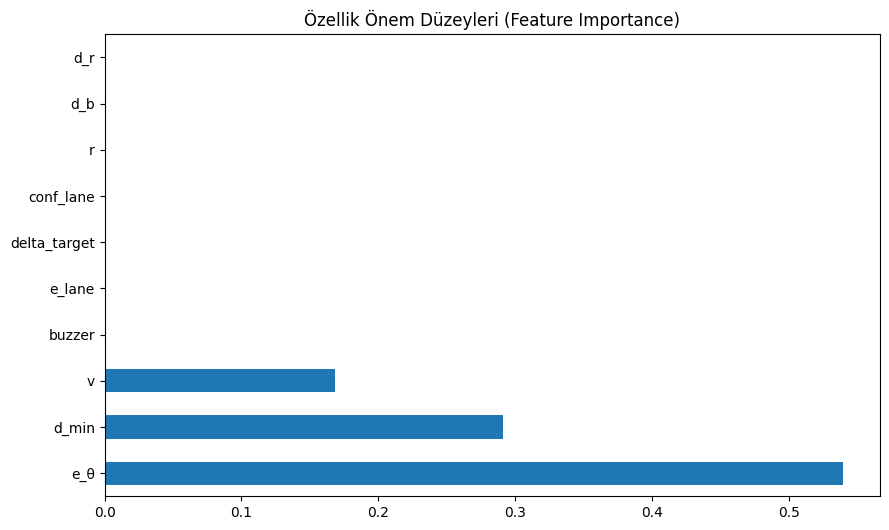

In [ ]:
rf_model = models["Gradient Boosting"]
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Özellik Önem Düzeyleri (Feature Importance)")
plt.show()

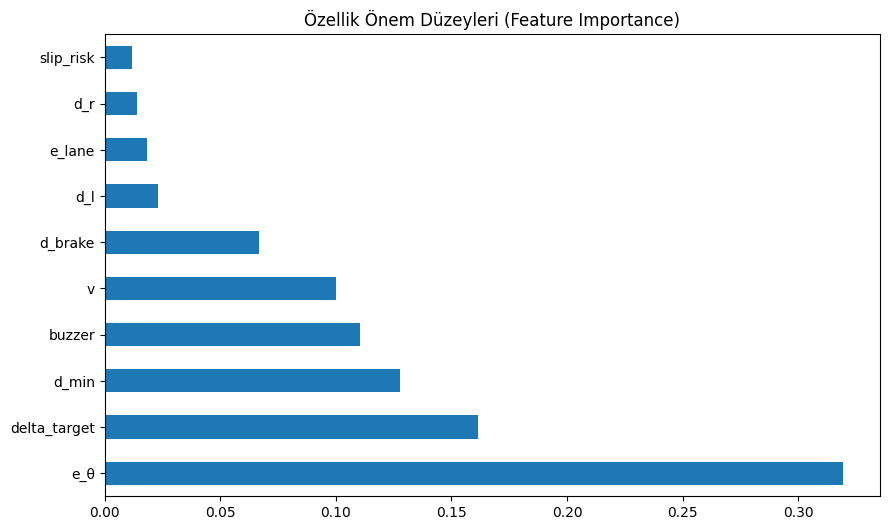

In [ ]:
rf_model = models["Random Forest"]
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Özellik Önem Düzeyleri (Feature Importance)")
plt.show()

--- kNN İçin Özellik Analizi (Permutation Importance) ---


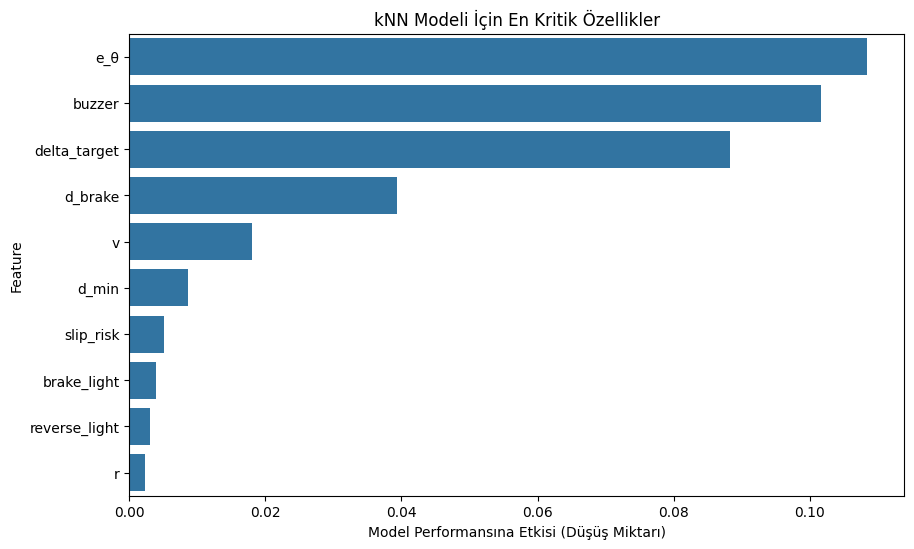

En baskın özellik: e_θ (Skor: 0.1085)

--- SVM İçin Özellik Analizi (Permutation Importance) ---


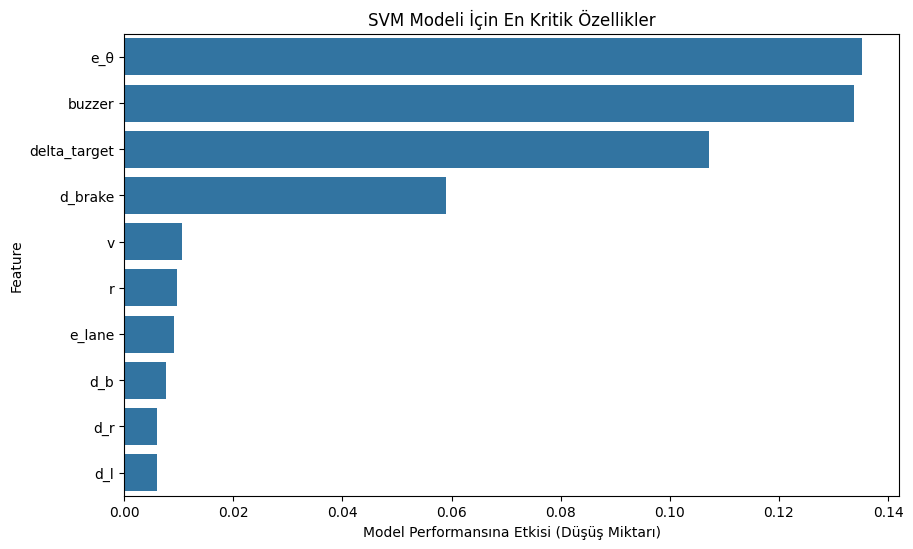

En baskın özellik: e_θ (Skor: 0.1353)



In [ ]:
from sklearn.inspection import permutation_importance
target_models = ['kNN', 'SVM']

for name in target_models:
    print(f"--- {name} İçin Özellik Analizi (Permutation Importance) ---")
    model = models[name]

    result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance_df['Importance'].head(10), y=importance_df['Feature'].head(10))
    plt.title(f"{name} Modeli İçin En Kritik Özellikler")
    plt.xlabel("Model Performansına Etkisi (Düşüş Miktarı)")
    plt.show()

    top_feature = importance_df.iloc[0]
    print(f"En baskın özellik: {top_feature['Feature']} (Skor: {top_feature['Importance']:.4f})\n")

In [ ]:
temiz_sutunlar = ['id', 'label', 'score','buzzer', 'e_θ', 'delta_target']
X_temiz = df.drop(temiz_sutunlar, axis=1)
y = df['label']

In [ ]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_temiz, y, test_size=0.2, random_state=42)
X_train_t_scaled = scaler.fit_transform(X_train_t)
X_test_t_scaled = scaler.transform(X_test_t)

temiz_sonuclar = []
models2 = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42), # probability=True ROC için gerekli
    "kNN": KNeighborsClassifier(n_neighbors=5)
    }

In [ ]:
for name, model in models2.items():
    model.fit(X_train_t_scaled, y_train_t)
    y_pred_t = model.predict(X_test_t_scaled)
    y_prob_t = model.predict_proba(X_test_t_scaled)[:, 1]

    temiz_sonuclar.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test_t, y_pred_t),
        "Precision": precision_score(y_test_t, y_pred_t),
        "Recall": recall_score(y_test_t, y_pred_t),
        "F1-Score": f1_score(y_test_t, y_pred_t),
        "ROC-AUC": roc_auc_score(y_test_t, y_prob_t)
    })

temiz_sonuclar_df = pd.DataFrame(temiz_sonuclar).sort_values(by="Accuracy", ascending=False)
print("--- Temizlenmiş Veri Modeli Performansı ---")
display(temiz_sonuclar_df)

--- Temizlenmiş Veri Modeli Performansı ---


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
3,SVM,0.810667,0.836077,0.955029,0.891603,0.866361
2,Gradient Boosting,0.808000,0.865234,0.905560,0.884938,0.880641
0,Logistic Regression,0.807333,0.853788,0.921504,0.886355,0.857722
1,Random Forest,0.807333,0.877526,0.887572,0.882520,0.879486
4,kNN,0.805333,0.861694,0.906787,0.883665,0.816670


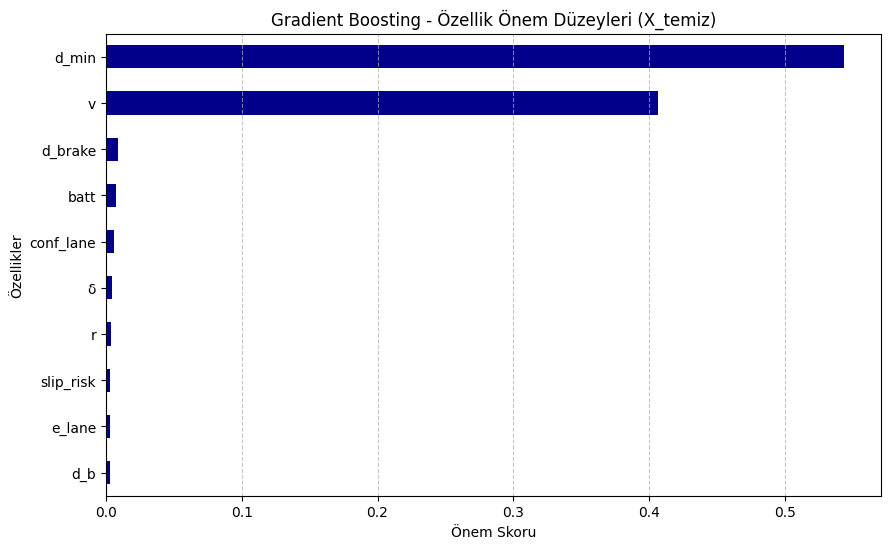

In [ ]:
gb_model = models2["Gradient Boosting"]

feature_importances = pd.Series(gb_model.feature_importances_, index=X_temiz.columns)

plt.figure(figsize=(10, 6))

feature_importances.nlargest(10).sort_values(ascending=True).plot(kind='barh', color='darkblue')

plt.title("Gradient Boosting - Özellik Önem Düzeyleri (X_temiz)")
plt.xlabel("Önem Skoru")
plt.ylabel("Özellikler")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

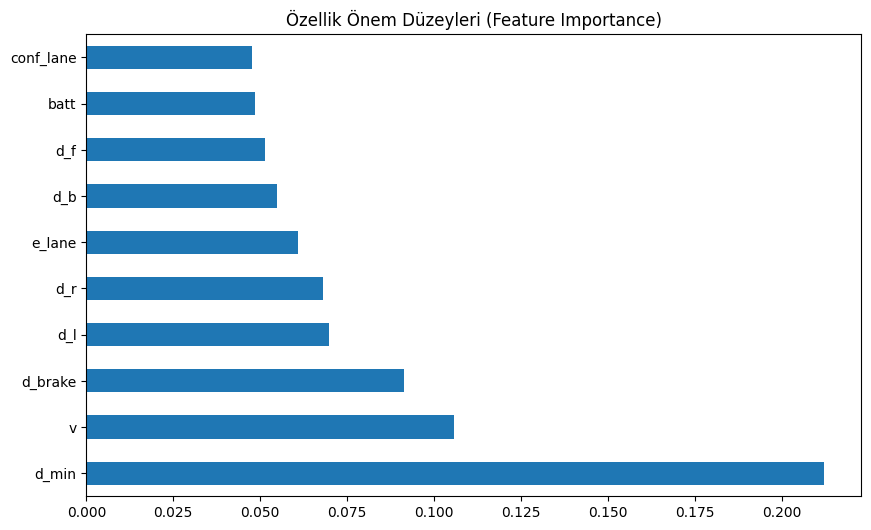

In [ ]:
rf_model = models2["Random Forest"]
feature_importances = pd.Series(rf_model.feature_importances_, index=X_temiz.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Özellik Önem Düzeyleri (Feature Importance)")
plt.show()

--- kNN İçin Özellik Analizi (Permutation Importance) ---


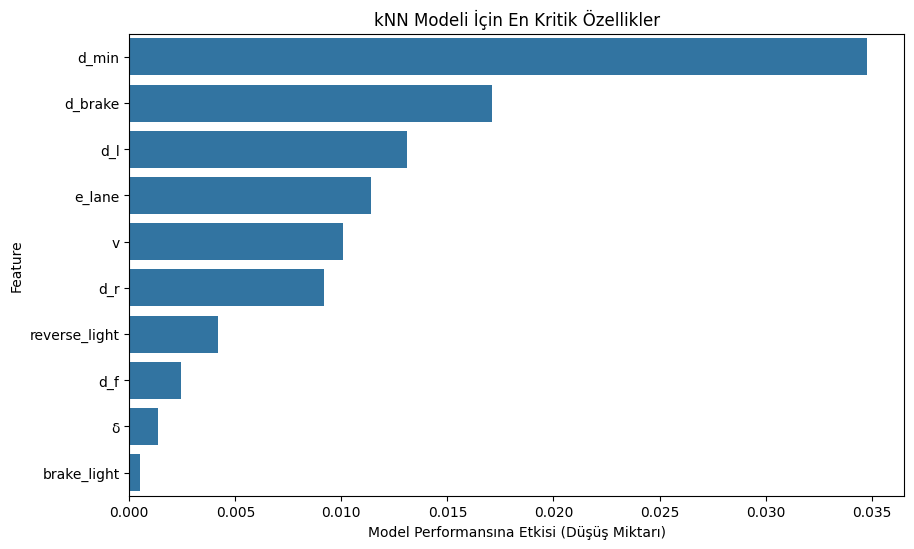

En baskın özellik: d_min (Skor: 0.0348)

--- SVM İçin Özellik Analizi (Permutation Importance) ---


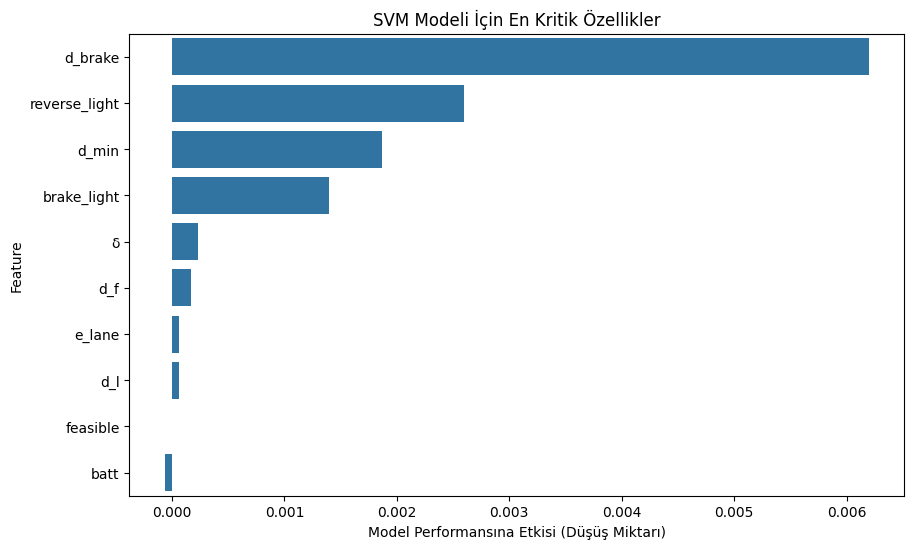

En baskın özellik: d_brake (Skor: 0.0062)

--- Logistic Regression İçin Özellik Analizi (Permutation Importance) ---


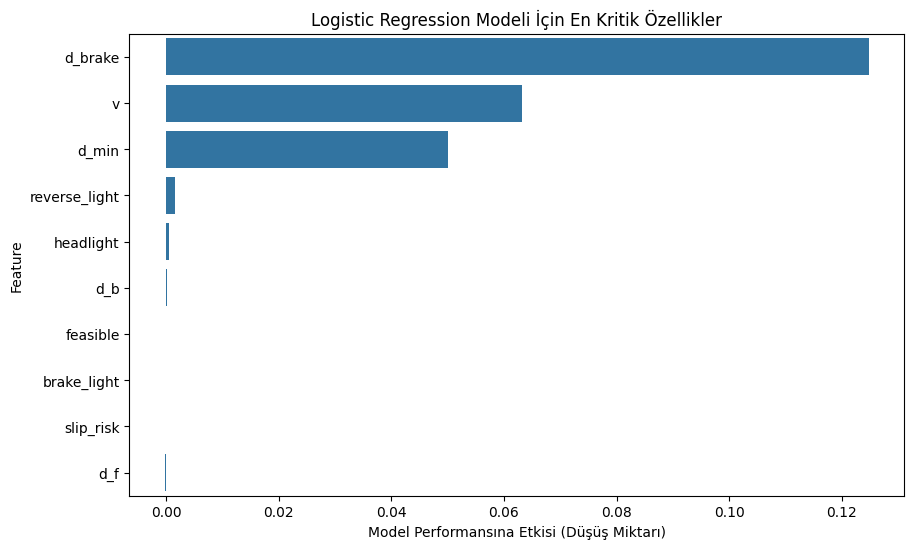

En baskın özellik: d_brake (Skor: 0.1248)



In [ ]:
from sklearn.inspection import permutation_importance
target_models = ['kNN', 'SVM','Logistic Regression']

for name in target_models:
    print(f"--- {name} İçin Özellik Analizi (Permutation Importance) ---")
    model = models2[name]

    result = permutation_importance(model, X_test_t_scaled, y_test_t, n_repeats=10, random_state=42, n_jobs=-1)

    importance_df = pd.DataFrame({
        'Feature': X_temiz.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance_df['Importance'].head(10), y=importance_df['Feature'].head(10))
    plt.title(f"{name} Modeli İçin En Kritik Özellikler")
    plt.xlabel("Model Performansına Etkisi (Düşüş Miktarı)")
    plt.show()

    top_feature = importance_df.iloc[0]
    print(f"En baskın özellik: {top_feature['Feature']} (Skor: {top_feature['Importance']:.4f})\n")

########## Logistic Regression Modeli İçin Görseller Hazırlanıyor ##########


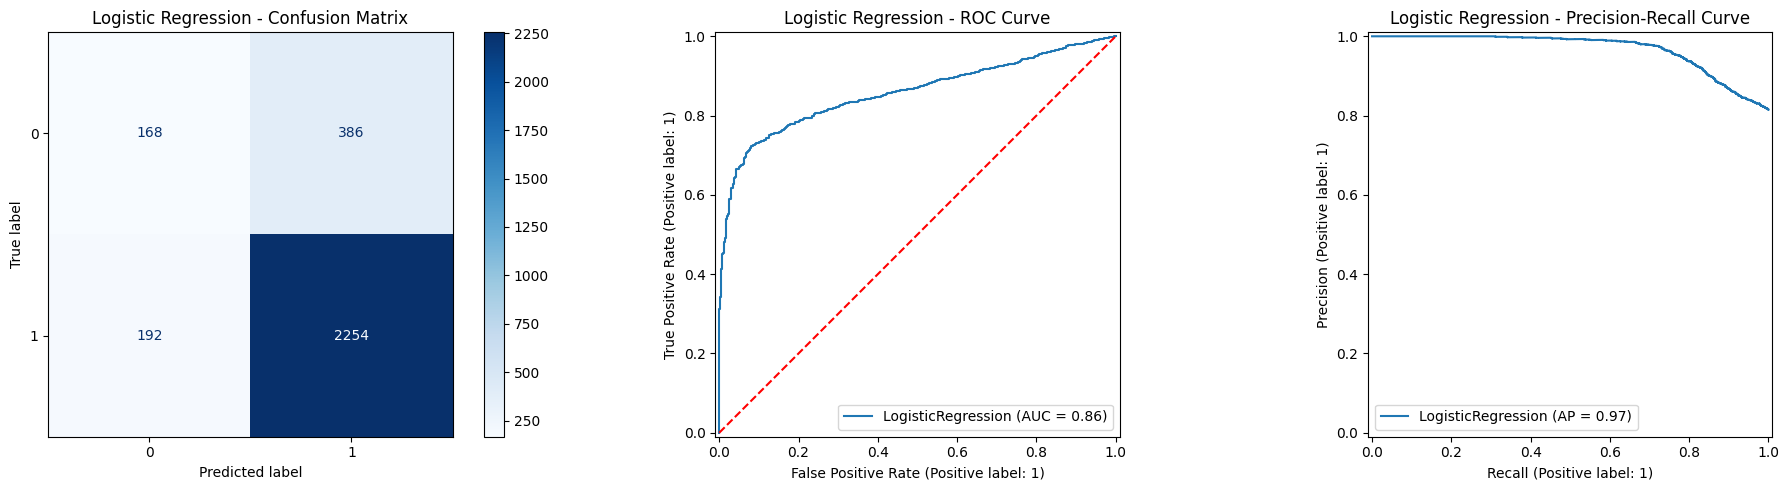



########## Random Forest Modeli İçin Görseller Hazırlanıyor ##########


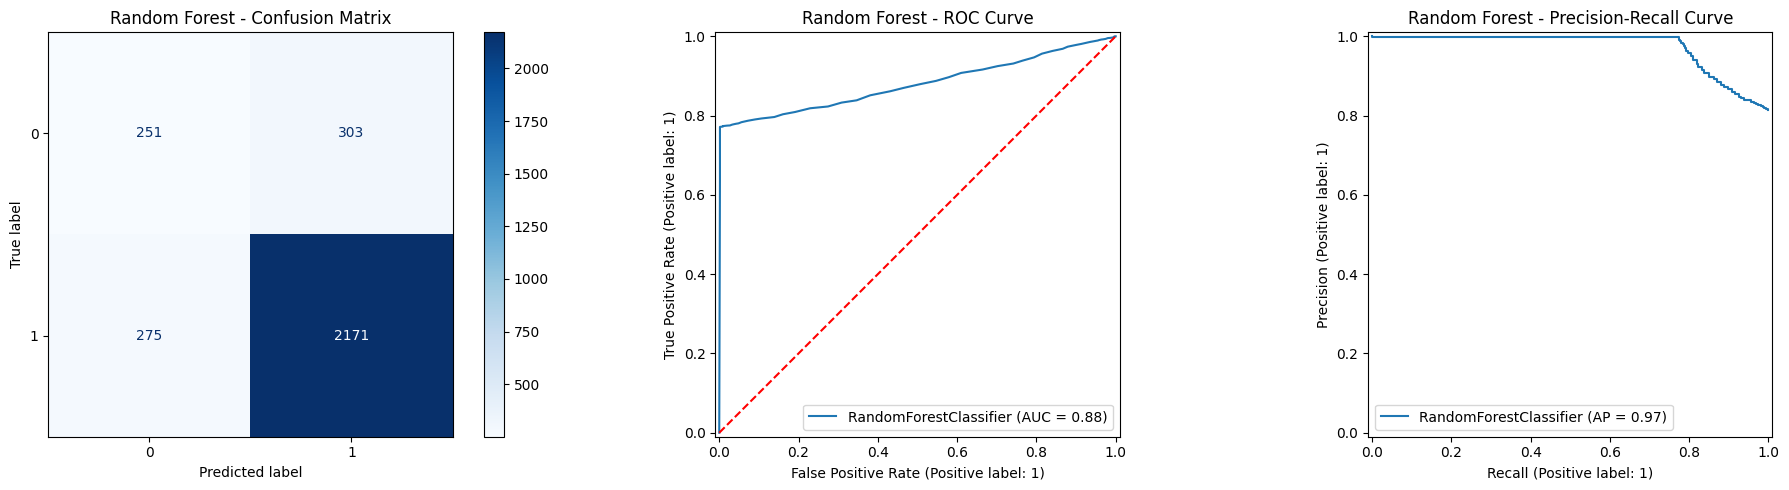



########## Gradient Boosting Modeli İçin Görseller Hazırlanıyor ##########


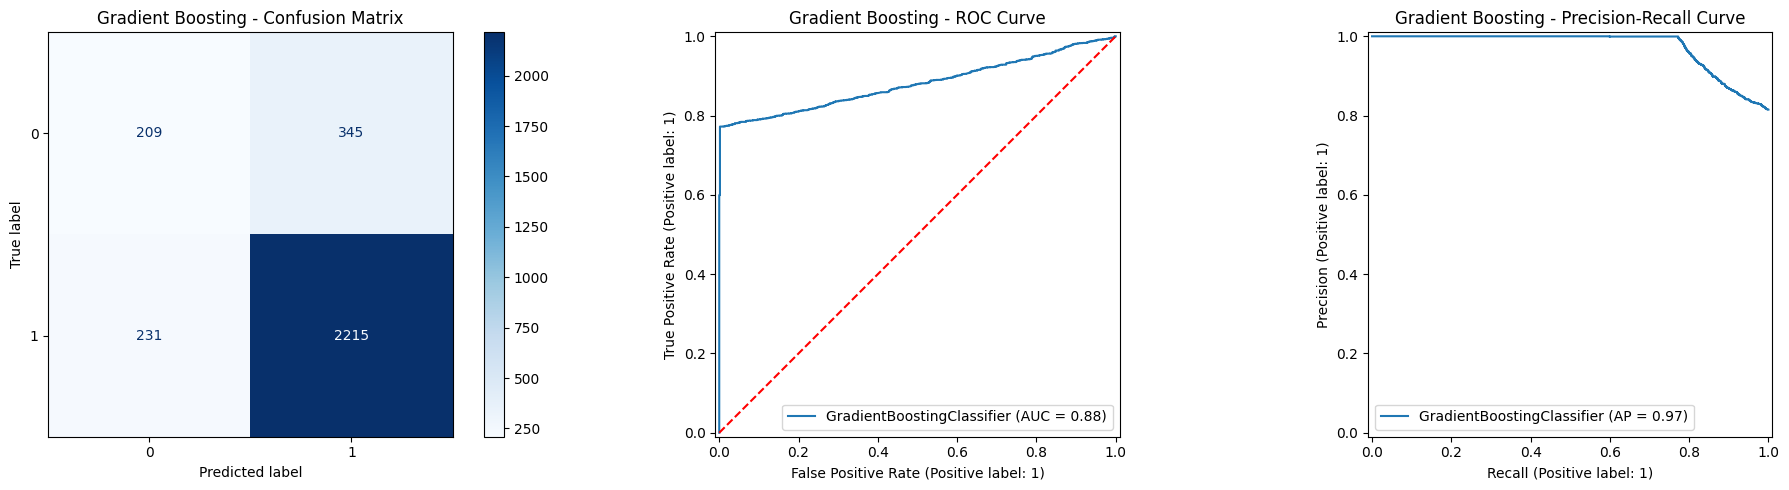



########## SVM Modeli İçin Görseller Hazırlanıyor ##########


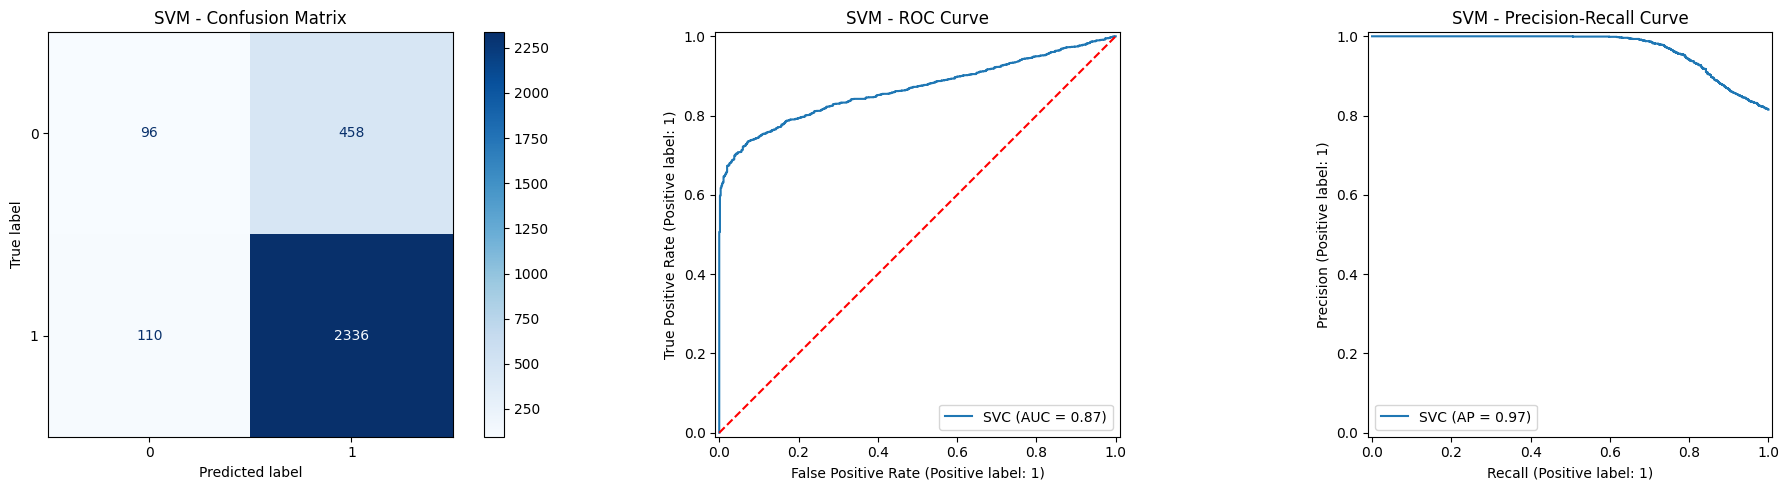



########## kNN Modeli İçin Görseller Hazırlanıyor ##########


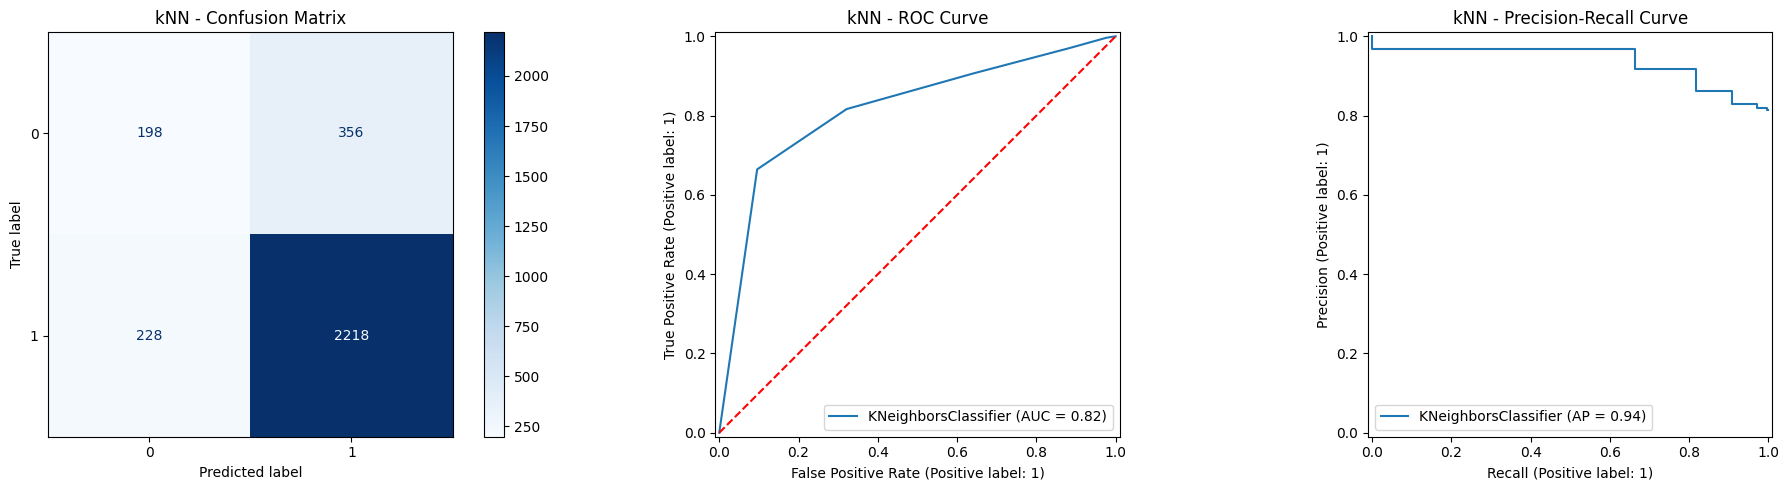

In [ ]:
for name, model in models2.items():
    print(f"########## {name} Modeli İçin Görseller Hazırlanıyor ##########")


    model.fit(X_train_t_scaled, y_train_t)

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    ConfusionMatrixDisplay.from_estimator(model, X_test_t_scaled, y_test_t, ax=axes[0], cmap='Blues')
    axes[0].set_title(f"{name} - Confusion Matrix")

    RocCurveDisplay.from_estimator(model, X_test_t_scaled, y_test_t, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], 'r--', label='Rastgele Tahmin')
    axes[1].set_title(f"{name} - ROC Curve")


    PrecisionRecallDisplay.from_estimator(model, X_test_t_scaled, y_test_t, ax=axes[2])
    axes[2].set_title(f"{name} - Precision-Recall Curve")


    plt.tight_layout()
    plt.show()
    print("\n" + "="*80 + "\n")